# Implemenation of Vanilla Neural Network for Classification on MNIST dataset 

## Implementation of Neural Network

### Sigmoid activation function and it's derivative 

In [1]:
def sigmoid(x):
    return 1./(1 + np.exp(-x))

def deriv_sigmoid(x):
    return (x)*(1-(x))

def relu(x):
    x[x<0.0] = 0.0
    return x

def deriv_relu(x):
    x[x>0.0] = 1.0
    return x

### Neural network class for forward propagation/backward propagation

In [2]:
class Neural_Network(object):
    """
    Args: input_dim:        this is for input dimension of data
          hidden_units:     list of number of hidden units in each layer 
          classes:          Number of classes  (in Iris dataset it is 3)
          num_layers:       Number of hidden layers
          dropout_percent:  Dropout percent (if 0.1, it means drop 10% of neurons are dropped)
          reg:              this is a regularization term used for preventing overfitting, if needed use it.
          learning_rate:    This is a learning parameter used for Stochastic gradient descent update
          hid_act:          In this task sigmoid neurons
          hid_act_derivative: This is a derivative of sigmoid neuron used for back propagation
    """
    def __init__(self, input_dim=4, hidden_units=[200], classes=10, num_layers=1, 
                 dropout_percent = 0.1, reg=0.0, learning_rate=0.1, hid_act=relu, 
                 hid_act_derivative=deriv_relu):
        
        self.input_dim= input_dim
        self.hidden_units = hidden_units
        self.classes = classes
        self.learning_rate = learning_rate
        self.num_layers=num_layers
        self.dropout_percent = dropout_percent
        self.hid_act = hid_act
        self.hid_act_derivative = hid_act_derivative
        self.reg = reg
        self.make_network()
        
    def make_network(self):
        """
        create the vanilla neural network. The number of layers and hidden units are defined in constructor.
        """
        self.weights = [] # neural network weights
        self.biases = [] # biases
        for i in range(self.num_layers+1): # if 2, layers 0,1,2 weights {0,1,2}
            if i==0:
                self.weights.append(0.01*np.random.randn(self.input_dim,self.hidden_units[i]))
                self.biases.append(np.zeros((1,self.hidden_units[i])))
                
            elif i<self.num_layers:
                self.weights.append(0.01*np.random.randn(self.hidden_units[i-1], self.hidden_units[i]))
                self.biases.append(np.zeros((1,self.hidden_units[i])))
                
            elif i==self.num_layers:
                self.weights.append(0.01 * np.random.randn(self.hidden_units[i-1],self.classes))
                self.biases.append(np.zeros((1,self.classes)))
                
    def forward(self, XX, yy, training = False):
        """
        calculates the forward propagation
        """
        self.h = [] # saving hidden layer output
        self.drop = [] # saving the dropout values
        for i in range(self.num_layers): # if num_layers=2, i = 0,1,
            val = self.hid_act(np.dot(XX,self.weights[i])+self.biases[i])
            if training:
                self.drop.append(np.random.binomial(1,1-self.dropout_percent, size=val.shape)[0])
                XX = val*self.drop[-1]
            else:
                XX = val/(1-self.dropout_percent)
            self.h.append(XX)
            
        linear_output = np.dot(val, self.weights[-1])+self.biases[-1]
        exp_scores = np.exp(linear_output)
        probs = exp_scores/np.sum(exp_scores, axis=1, keepdims=True)
        self.h.append(probs)
        correct_logprobs = -np.log(probs[range(XX.shape[0]),yy])
        data_loss = np.sum(correct_logprobs)/XX.shape[0]
        
        return (probs, data_loss)
        
    def backward(self,X_in, y_predict, y_target):
        """
        calculate the backward propagation and update the weights
        """
        dscores = y_predict
        dscores[range(X_in.shape[0]),y_target] -= 1
        dscores /= X_in.shape[0]
        delta = dscores
        self.dw = {}
        self.db = {}
        for i in reversed(range(self.num_layers+1)):
            if i>0:
                self.dw[i]= np.dot(self.h[i-1].T, delta)
                self.db[i] = np.sum(delta, axis=0, keepdims=True)
                delta = np.dot(delta, self.weights[i].T)*self.hid_act_derivative(self.h[i-1])*self.drop[i-1]
            else:
                self.dw[i]= np.dot(X_in.T, delta)
                self.db[i] = np.sum(delta, axis=0, keepdims=True)
                
        for i in range(self.num_layers+1):
            self.weights[i] += -self.learning_rate * (self.dw[i] + self.reg*self.dw[i])
            self.biases[i] += -self.learning_rate * (self.db[i] + self.reg*self.db[i])
        return None

## Classification on MNIST dataset

### import necessary packages

In [3]:
from sklearn.utils import shuffle
from sklearn import datasets
from sklearn.model_selection import train_test_split # for splitting train/valid/test data
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(123) # setting the random seed to produce the same random numbers for getting the same result

### import the MNIST dataset and split the dataset into train, validation

In [4]:
import numpy as np
np.random.seed(1234)
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
mnist = fetch_mldata('MNIST original')

#preprocess the data between 0 to 1
data = np.float32(mnist.data[:]) / 255.

X_train, X_test, y_train, y_test = train_test_split(data, mnist.target, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# changeing the shape of train_target and test_target as an array
y_train = y_train.reshape(-1,).astype(int)
y_val = y_val.reshape(-1,).astype(int)
y_test = y_test.reshape(-1,).astype(int)

/home/t-praveen/.virtualenvs/py35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Neural network parameters setting (number of layers, hidden units)

In [5]:
nn = Neural_Network(input_dim=28*28, hidden_units = [400, 400], num_layers=2, classes=10, 
                    dropout_percent=0.0,hid_act=relu, hid_act_derivative=deriv_relu)
epochs = 50
batch_size = 64
num_batches = X_train.shape[0]/batch_size

### Training and testing

In [6]:
train_loss = []
validation_loss = []
test_loss = []
train_accuracy = []
validation_accuracy = []
test_accuracy = []
for i in range(epochs):
    xx,yy = shuffle(X_train, y_train) # shuffling the data
    for j in range(int(num_batches)):
        probabalities, loss = nn.forward(xx[j*batch_size:(j+1)*batch_size,:], yy[j*batch_size:(j+1)*batch_size], training=True)
        nn.backward(xx[j*batch_size:(j+1)*batch_size,:],probabalities,yy[j*batch_size:(j+1)*batch_size])    
    
    train_prob, train_loss_ = nn.forward(X_train, y_train) #, train_loss_
    train_accu = np.mean(np.argmax(train_prob, axis=1) == y_train)
    train_accuracy.append(train_accu) # train accuracy of after training of one epoch finished
    train_loss.append(train_loss_)
    
    val_prob, val_loss_ = nn.forward(X_val, y_val) #, val_loss_
    val_accu = np.mean(np.argmax(val_prob, axis=1) == y_val)
    validation_accuracy.append(val_accu) # validation accuracy
    validation_loss.append(val_loss_)
    
    test_prob, test_loss_ = nn.forward(X_test, y_test) #, test_loss_
    test_accu = np.mean(np.argmax(test_prob, axis=1) == y_test)
    test_accuracy.append(test_accu) # test accuracy
    test_loss.append(test_loss_)
    print('epoch', i, 'train_accu', train_accu, 'validation_accu', val_accu, 'test_accu',test_accu)


epoch 0 train_accu 0.9144821428571429 validation_accu 0.9157142857142857 test_accu 0.9077142857142857
epoch 1 train_accu 0.9512857142857143 validation_accu 0.9507142857142857 test_accu 0.947
epoch 2 train_accu 0.966375 validation_accu 0.9645714285714285 test_accu 0.958
epoch 3 train_accu 0.9753035714285714 validation_accu 0.9691428571428572 test_accu 0.9661428571428572
epoch 4 train_accu 0.9808214285714286 validation_accu 0.9724285714285714 test_accu 0.9692857142857143
epoch 5 train_accu 0.9808571428571429 validation_accu 0.973 test_accu 0.9692857142857143
epoch 6 train_accu 0.9845892857142857 validation_accu 0.976 test_accu 0.9712857142857143
epoch 7 train_accu 0.9889464285714286 validation_accu 0.9765714285714285 test_accu 0.9748571428571429
epoch 8 train_accu 0.9901071428571429 validation_accu 0.9765714285714285 test_accu 0.9761428571428571
epoch 9 train_accu 0.9933928571428572 validation_accu 0.979 test_accu 0.977
epoch 10 train_accu 0.9932321428571429 validation_accu 0.97928571428

### Printing the train/valid/test accuracy after training

In [7]:
print('train_accuracy', train_accuracy[-1])
print('val_accuracy', validation_accuracy[-1])
print('test_accuracy', test_accuracy[-1])

train_accuracy 1.0
val_accuracy 0.9815714285714285
test_accuracy 0.9804285714285714


### Plotting the loss values for each epoch

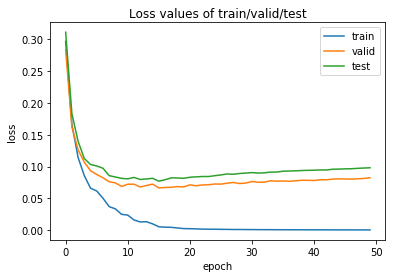

In [8]:
# Plotting the loss values 
plt.plot(train_loss)
plt.plot(validation_loss)
plt.plot(test_loss)
plt.title('Loss values of train/valid/test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid','test'], loc='upper right')
plt.show()

### Plotting the accuracy values for each epoch

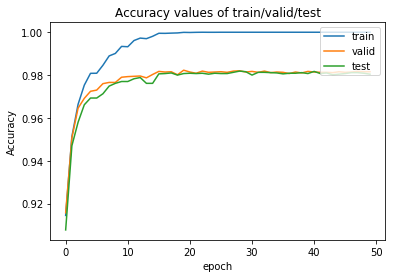

In [9]:
# plotting the accuracy values
plt.plot(train_accuracy)
plt.plot(validation_accuracy)
plt.plot(test_accuracy)
plt.title('Accuracy values of train/valid/test')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid','test'], loc='upper right')
plt.show()